In [1]:
import csv
import numpy as np

from joblib import parallel_backend
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

This notbook will try different methods for clustering subcluster modules.
 I will use a small test set generated from mibig4.

In [2]:
def string_to_tokenized_genes(genes_string):
    return [tuple(gene.split(";")) for gene in genes_string.split(",")]


class StatModule:
    def __init__(
        self,
        module_id,
        strictest_pval,
        tokenised_genes,
    ):
        self.module_id = module_id
        self.n_genes = len(tokenised_genes)
        self.n_domains = sum(len(gene) for gene in tokenised_genes)
        self.tokenised_genes = tokenised_genes
        self.strictest_pval = strictest_pval

    def __repr__(self):
        return (
            f"StatModule("
            f"module_id={self.module_id}, "
            f"strictest_pval={self.strictest_pval}, "
            f"n_genes={self.n_genes}, "
            f"n_domains={self.n_domains}, "
            f"tokenised_genes={self.tokenised_genes})"
        )


def read_stat_modules(file_path):
    """
    Reads statistical modules from a tab-separated file into a list of StatModules.

    Parameters:
        file_path (str): The file path to the input file.

    Returns:
        dict: A dictionary where keys are module IDs and values are StatModule objects.
    """
    with open(file_path, "r", newline="") as infile:
        reader = csv.DictReader(infile, delimiter="\t")
        modules = {}
        for row in reader:
            module_id = "M" + row["module_id"]
            strictest_pval = float(row["strictest_pval"])
            tokenised_genes = string_to_tokenized_genes(row["tokenised_genes"])
            if module_id in modules:
                print(
                    f"Warning: Duplicate module ID {module_id}. Keeping the first one."
                )
                continue
            module = StatModule(
                module_id=module_id,
                strictest_pval=strictest_pval,
                tokenised_genes=tokenised_genes,
            )
            modules[module_id] = module
        return modules


modules_file_path = "../data/PRESTO-STAT_modules.txt"
modules = read_stat_modules(modules_file_path)

print(f"Loaded {len(modules)} modules from {modules_file_path}")
print("Example module:")
print(modules["M1"])

Loaded 108085 modules from ../data/PRESTO-STAT_modules.txt
Example module:
StatModule(module_id=M1, strictest_pval=0.0, n_genes=4, n_domains=6, tokenised_genes=[('ACPS_c6',), ('AMP-binding_c30', 'AMP-binding_C_c39'), ('Chorismate_bind_c14',), ('Isochorismatase_c20', 'PP-binding_c39')])


First, we will convert the modules into a binary matrix

In [3]:
def tokenized_genes_to_string(tokenized_genes):
    return ",".join([";".join(gene) for gene in tokenized_genes])


def create_binary_matrix(modules: dict):
    """
    Create a sparse, binary feature matrix from the modules.
    Each row corresponds to a module and each column corresponds to a gene.
    """
    vectorizer = CountVectorizer(
        lowercase=False,
        binary=True,
        dtype=np.int64, # use np.int8 to save memory (binary matrix)
        token_pattern=r"(?u)[^,]+",  # features/genes are separated by ','
    )
    corpus = [tokenized_genes_to_string(m.tokenised_genes) for m in modules.values()] # corpus must be list of strings
    matrix = vectorizer.fit_transform(corpus) 
    colnames = vectorizer.get_feature_names_out()
    rownames = sorted(modules.keys())
    return matrix, colnames, rownames


binary_feature_matrix, colnames, rownames = create_binary_matrix(modules)

module_ids = rownames
genes = colnames
print(f"Created binary feature matrix: {type(binary_feature_matrix)}, {binary_feature_matrix.dtype}, {binary_feature_matrix.shape}")
print(f"Number of modules (rows): {len(module_ids)}")
print(f"Number of genes (columns): {len(genes)}")
print(f"Size in memory: {binary_feature_matrix.data.nbytes + binary_feature_matrix.indptr.nbytes + binary_feature_matrix.indices.nbytes} bytes")

Created binary feature matrix: <class 'scipy.sparse._csr.csr_matrix'>, int64, (108085, 9487)
Number of modules (rows): 108085
Number of genes (columns): 9487
Size in memory: 8628200 bytes


# BitBIRCH

In [4]:
import bitbirch.bitbirch as bb
import bitbirch.plotting_utils as plotting_utils

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Now let's check the quality. As stated about we need them to be binary of dtype int64.

In [5]:
feats = binary_feature_matrix.toarray()
#type(feats), feats.dtype, feats.shape

print(f'Bits are binary: {np.all(np.isin(feats, [0, 1]))}')
print(f'Data type is int64: {feats.dtype == np.int64 or feats.dtype == np.float64}')

Bits are binary: True
Data type is int64: True


Now we are going to set a threshold and branching factor for our clustering

According to our observations in the refinement paper, we determined that the best way was to do initially diameter birch. We are going to fit now the fingerprints.

In [6]:
def run_bitbirch_and_plot(feats, branching_factor, threshold, merge_method):
    bb.set_merge(merge_method)
    brc = bb.BitBirch(threshold=threshold, branching_factor=branching_factor)
    %time brc.fit(feats)

    clusters = brc.get_cluster_mol_ids()
    cluster_lengths = [len(c) for c in clusters]

    print(f"Number of modules: {sum(cluster_lengths)}")
    print(f"Number of families: {len(clusters)}")
    print(f"Average family size: {np.mean(cluster_lengths):.2f}")

    plt.figure(figsize=(8, 5))
    plt.hist(cluster_lengths, bins=50, color='skyblue', edgecolor='black', log=True)
    plt.xlabel('Cluster Size')
    plt.ylabel('Number of Clusters (log scale)')
    plt.title('Distribution of Cluster Sizes')
    plt.show()

    plotting_utils.tsne_plot(brc, feats, title="BitBirch")

    return clusters

/lustre/BIF/nobackup/lien002/software/bitbirch/bitbirch/bitbirch.py:141: RuntimeWarning: invalid value encountered in divide
  sims_med = a_centroid / (pop_counts + np.sum(centroid) - a_centroid)
/lustre/BIF/nobackup/lien002/software/bitbirch/bitbirch/bitbirch.py:148: RuntimeWarning: invalid value encountered in divide
  sims_mol1 = a_mol1 / (pop_counts + pop_counts[mol1] - a_mol1)
/lustre/BIF/nobackup/lien002/software/bitbirch/bitbirch/bitbirch.py:155: RuntimeWarning: invalid value encountered in divide
  sims_mol2 = a_mol2 / (pop_counts + pop_counts[mol2] - a_mol2)


CPU times: user 1min 52s, sys: 3.84 s, total: 1min 56s
Wall time: 1min 56s
Number of modules: 108085
Number of families: 87988
Average family size: 1.23


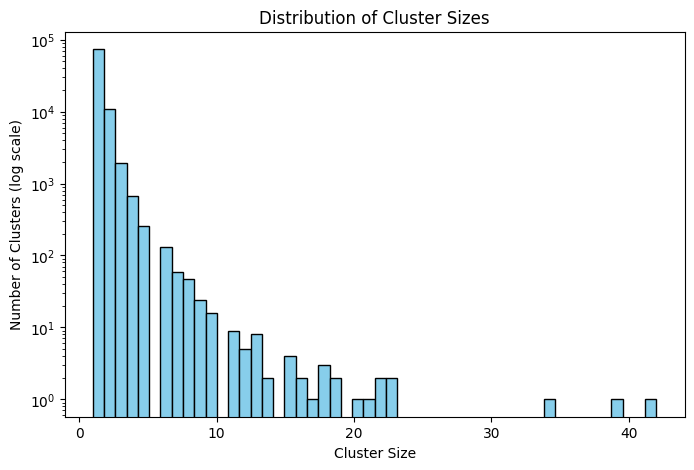

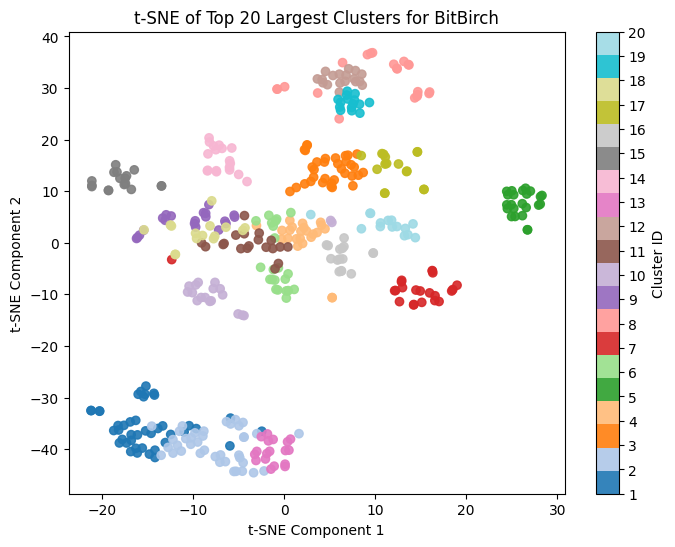

In [49]:
branching_factor = 70
threshold = 0.50
merge_method = 'diameter'

clusters = run_bitbirch_and_plot(feats, branching_factor, threshold, merge_method)

/lustre/BIF/nobackup/lien002/software/bitbirch/bitbirch/bitbirch.py:141: RuntimeWarning: invalid value encountered in divide
  sims_med = a_centroid / (pop_counts + np.sum(centroid) - a_centroid)
/lustre/BIF/nobackup/lien002/software/bitbirch/bitbirch/bitbirch.py:148: RuntimeWarning: invalid value encountered in divide
  sims_mol1 = a_mol1 / (pop_counts + pop_counts[mol1] - a_mol1)
/lustre/BIF/nobackup/lien002/software/bitbirch/bitbirch/bitbirch.py:155: RuntimeWarning: invalid value encountered in divide
  sims_mol2 = a_mol2 / (pop_counts + pop_counts[mol2] - a_mol2)


CPU times: user 3min 12s, sys: 7.11 s, total: 3min 20s
Wall time: 3min 20s
Number of modules: 108085
Number of families: 74761
Average family size: 1.45


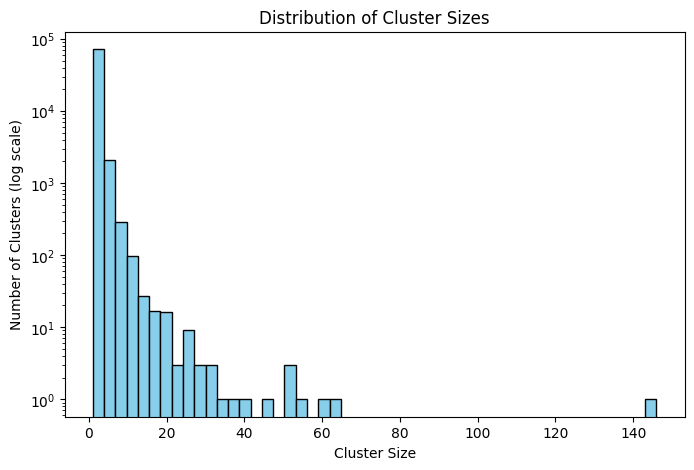

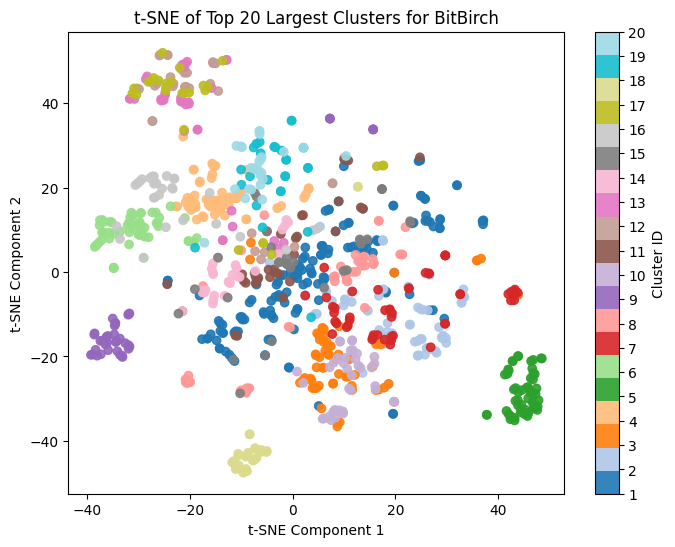

In [50]:
branching_factor = 70
threshold = 0.50
merge_method = 'radius'

clusters = run_bitbirch_and_plot(feats, branching_factor, threshold, merge_method)

CPU times: user 4min 7s, sys: 5.67 s, total: 4min 13s
Wall time: 4min 13s
Number of modules: 108085
Number of families: 93282
Average family size: 1.16


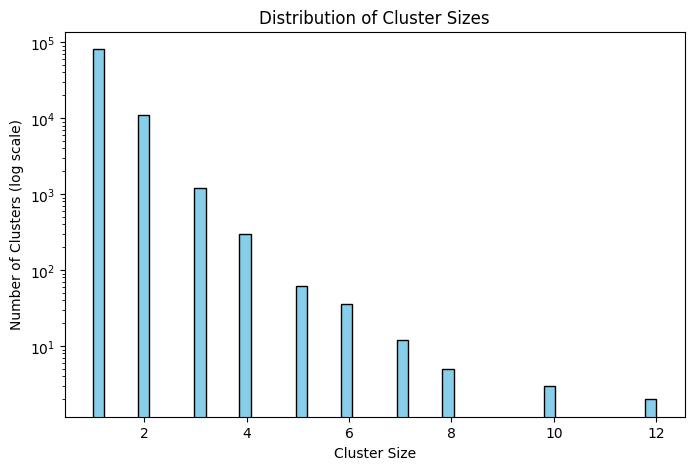

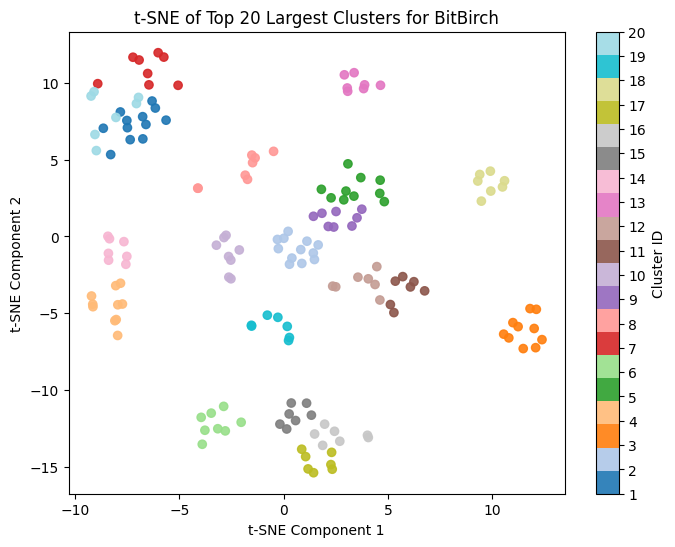

In [7]:
branching_factor = 70
threshold = 0.50
merge_method = 'tolerance'

clusters = run_bitbirch_and_plot(feats, branching_factor, threshold, merge_method)

CPU times: user 3min 5s, sys: 5.48 s, total: 3min 10s
Wall time: 3min 10s
Number of modules: 108085
Number of families: 86581
Average family size: 1.25


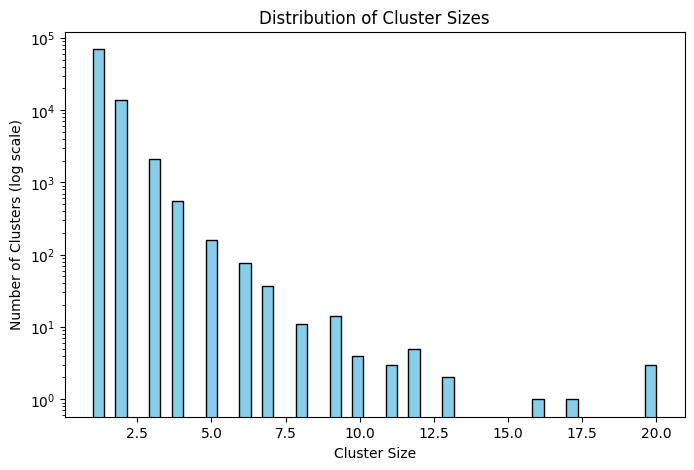

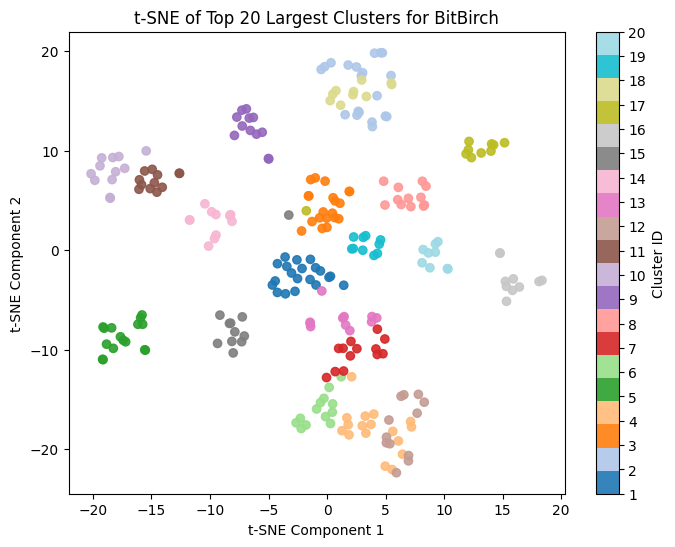

In [10]:
branching_factor = 100
threshold = 0.30
merge_method = 'tolerance'

clusters = run_bitbirch_and_plot(feats, branching_factor, threshold, merge_method)

/lustre/BIF/nobackup/lien002/software/bitbirch/bitbirch/bitbirch.py:141: RuntimeWarning: invalid value encountered in divide
  sims_med = a_centroid / (pop_counts + np.sum(centroid) - a_centroid)
/lustre/BIF/nobackup/lien002/software/bitbirch/bitbirch/bitbirch.py:148: RuntimeWarning: invalid value encountered in divide
  sims_mol1 = a_mol1 / (pop_counts + pop_counts[mol1] - a_mol1)
/lustre/BIF/nobackup/lien002/software/bitbirch/bitbirch/bitbirch.py:155: RuntimeWarning: invalid value encountered in divide
  sims_mol2 = a_mol2 / (pop_counts + pop_counts[mol2] - a_mol2)


Number of modules: 108085
Number of families: 88006
Average family size: 1.23


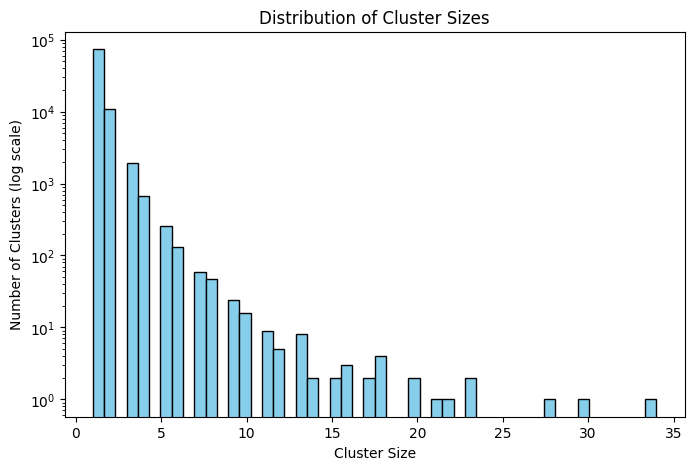

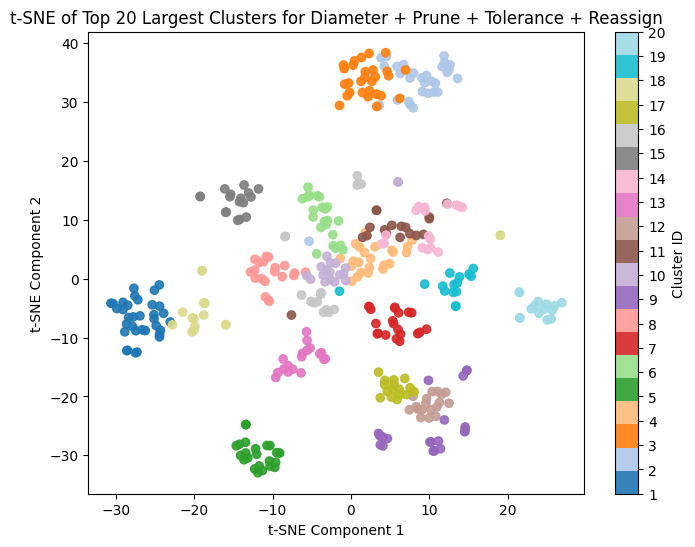

In [56]:
def diameter_prune_tolerance_reassign(fps, tol=0.05):
    bb.set_merge('diameter')
    brc = bb.BitBirch(branching_factor=branching_factor, threshold=threshold)
    brc.fit(fps, singly=False)
    bb.set_merge('tolerance', tolerance=tol)
    brc.prune(fps)
    brc.reassign(fps)

    clusters = brc.get_cluster_mol_ids()
    cluster_lengths = [len(c) for c in clusters]

    print(f"Number of modules: {sum(cluster_lengths)}")
    print(f"Number of families: {len(clusters)}")
    print(f"Average family size: {np.mean(cluster_lengths):.2f}")

    plt.figure(figsize=(8, 5))
    plt.hist(cluster_lengths, bins=50, color='skyblue', edgecolor='black', log=True)
    plt.xlabel('Cluster Size')
    plt.ylabel('Number of Clusters (log scale)')
    plt.title('Distribution of Cluster Sizes')
    plt.show()

    title = 'Diameter + Prune + Tolerance + Reassign'
    plotting_utils.tsne_plot(brc, feats, title=title)

    return clusters

clusters = diameter_prune_tolerance_reassign(feats)


In [12]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def plot_bitbirch_clusters(brc, feats):
    clusters = brc.get_cluster_mol_ids()
    # Find indices of all points in the top 20 largest clusters
    sort_clusters = sorted(clusters, key=lambda x: len(x), reverse=True)[:20]

    highlight_indices = [idx for cluster in sort_clusters for idx in cluster]
    highlight_set = set(highlight_indices)

    # Prepare cluster labels for all points: -1 for not in top clusters, 0-19 for cluster index
    cluster_labels = np.full(feats.shape[0], -1)
    for cluster_id, cluster in enumerate(sort_clusters):
        for idx in cluster:
            cluster_labels[idx] = cluster_id

    scaler = StandardScaler()
    feats_scaled = scaler.fit_transform(feats)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    feats_tsne = tsne.fit_transform(feats_scaled)

    plt.figure(figsize=(8, 6))
    # Plot all points in gray
    plt.scatter(feats_tsne[:, 0], feats_tsne[:, 1], c='lightgray', alpha=0.5, s=10, label='Other')

    # Plot highlighted clusters
    mask = cluster_labels != -1
    scatter = plt.scatter(
        feats_tsne[mask, 0], feats_tsne[mask, 1],
        c=cluster_labels[mask], cmap='tab20', alpha=0.9, s=20, label='Top 20 clusters'
    )
    cbar = plt.colorbar(scatter, label="Cluster ID")
    cbar.set_ticks(np.arange(20))
    cbar.set_ticklabels(np.arange(1, 21))
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title(f"t-SNE of All Modules, Top 20 Largest Clusters Colored (BitBirch)")

plot_bitbirch_clusters(brc, feats)

KeyboardInterrupt: 

In [31]:
clustered_module_ids = dict()
for cluster_id, cluster in enumerate(brc.get_cluster_mol_ids()):
    clustered_module_ids[cluster_id] = list()
    for idx in cluster:
        clustered_module_ids[cluster_id].append(module_ids[idx])

In [27]:
cluster_assignment = dict()
for cluster_id, cluster in clustered_module_ids.items():
    for module_id in cluster:
        cluster_assignment[module_id] = cluster_id
cluster_assignment

{'M85699': 0,
 'M8573': 0,
 'M85733': 0,
 'M85736': 0,
 'M85738': 0,
 'M85756': 0,
 'M85763': 0,
 'M85806': 0,
 'M85809': 0,
 'M85816': 0,
 'M85820': 0,
 'M85845': 0,
 'M85847': 0,
 'M85848': 0,
 'M85849': 0,
 'M85852': 0,
 'M85866': 0,
 'M85867': 0,
 'M85871': 0,
 'M85875': 0,
 'M85878': 0,
 'M85884': 0,
 'M85885': 0,
 'M85900': 0,
 'M85904': 0,
 'M85908': 0,
 'M85910': 0,
 'M85911': 0,
 'M85916': 0,
 'M85919': 0,
 'M85934': 0,
 'M85936': 0,
 'M85944': 0,
 'M85952': 0,
 'M85955': 0,
 'M85962': 0,
 'M85970': 0,
 'M8599': 0,
 'M86171': 0,
 'M87312': 0,
 'M87337': 0,
 'M87346': 0,
 'M857': 1,
 'M85705': 1,
 'M85711': 1,
 'M85713': 1,
 'M85735': 1,
 'M85739': 1,
 'M85748': 1,
 'M8575': 1,
 'M85750': 1,
 'M85772': 1,
 'M85777': 1,
 'M85783': 1,
 'M85791': 1,
 'M8580': 1,
 'M85800': 1,
 'M8581': 1,
 'M85857': 1,
 'M85858': 1,
 'M85861': 1,
 'M85868': 1,
 'M85889': 1,
 'M85893': 1,
 'M85894': 1,
 'M85898': 1,
 'M8590': 1,
 'M85907': 1,
 'M8591': 1,
 'M85938': 1,
 'M85942': 1,
 'M85948': 1,
 

In [35]:
outfile = f"../results/original_bitbirch_branch-{branching_factor}_theshold-{threshold}.txt"
with open(outfile, "w") as f:
    f.write("module_id\tfamily_id\n")
    for module_id in sorted(cluster_assignment):
        f.write(f"{module_id}\t{cluster_assignment[module_id]}\n")


outfile = f"../results/original_bitbirch_clusters_branch-{branching_factor}_theshold-{threshold}.txt"
with open(outfile, "w") as f:
    for cluster_id, module_ids in clustered_module_ids.items():
        f.write(f">Family {cluster_id}, {len(module_ids)} modules\n")
        for module_id in module_ids:
            module = modules[module_id]
            f.write(f"{module.module_id}\t{tokenized_genes_to_string(module.tokenised_genes)}\n")

# MiniBatchKMeans

In [ ]:
from sklearn.cluster import MiniBatchKMeans

k = 10000
%time kmeans = MiniBatchKMeans(n_clusters=k, batch_size=1000)
labels = kmeans.fit_predict(sparse_matrix)

# K-means

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [119]:
def run_kmeans(sparse_feature_matrix, k, cores):
    with parallel_backend("loky", n_jobs=cores):
        k_means = KMeans(
            n_clusters=k,
            n_init=20,
            max_iter=1000,
            random_state=595,
            verbose=0,
            tol=1e-6,
        ).fit(sparse_feature_matrix)
    return k_means


def plot_kmeans_clusters(k_means, sparse_feature_matrix):
    feats = binary_feature_matrix.toarray()
    k = k_means.n_clusters

    clusters = []
    for i in range(k):
        clusters.append([idx for idx, cluster_id in enumerate(k_means.labels_) if cluster_id == i])


    sort_clusters = sorted(clusters, key=lambda x: len(x), reverse=True)[:20]
    # #     # Map each mol ID to its cluster ID
    n_molecules = sum([len(x) for x in sort_clusters])


    cluster_labels = [0] * n_molecules

    fps_clusters = []#[0] * n_molecules
    cluster_labels = []#[0] * n_molecules

    for cluster_id, cluster in enumerate(sort_clusters):
        for idx in cluster:
            fps_clusters.append(feats[idx])
            cluster_labels.append(int(cluster_id))


    scaler = StandardScaler()
    fps_scaled = scaler.fit_transform(fps_clusters)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    fps_tsne = tsne.fit_transform(fps_scaled)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(fps_tsne[:, 0], fps_tsne[:, 1], c=cluster_labels, cmap='tab20', alpha=0.9)
    cbar = plt.colorbar(scatter, label="Cluster ID")
    cbar.set_ticks(np.arange(20))  # Set ticks at the center of each color
    cbar.set_ticklabels(np.arange(1, 21))  # Set labels from 1 to 20
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title(f"t-SNE of Top 20 Largest Clusters for K-Means (k={k})")

In [127]:
def plot_kmeans_clusters(k_means, sparse_feature_matrix):
    feats = binary_feature_matrix.toarray()
    k = k_means.n_clusters

    # Find indices of all points in the top 20 largest clusters
    sort_clusters = sorted(
        [[idx for idx, cluster_id in enumerate(k_means.labels_) if cluster_id == i] for i in range(k)],
        key=lambda x: len(x), reverse=True
    )[:20]
    highlight_indices = [idx for cluster in sort_clusters for idx in cluster]
    highlight_set = set(highlight_indices)

    # Prepare cluster labels for all points: -1 for not in top clusters, 0-19 for cluster index
    cluster_labels = np.full(feats.shape[0], -1)
    for cluster_id, cluster in enumerate(sort_clusters):
        for idx in cluster:
            cluster_labels[idx] = cluster_id

    scaler = StandardScaler()
    feats_scaled = scaler.fit_transform(feats)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    feats_tsne = tsne.fit_transform(feats_scaled)

    plt.figure(figsize=(8, 6))
    # Plot all points in gray
    plt.scatter(feats_tsne[:, 0], feats_tsne[:, 1], c='lightgray', alpha=0.5, s=10, label='Other')

    # Plot highlighted clusters
    mask = cluster_labels != -1
    scatter = plt.scatter(
        feats_tsne[mask, 0], feats_tsne[mask, 1],
        c=cluster_labels[mask], cmap='tab20', alpha=0.9, s=20, label='Top 20 clusters'
    )
    cbar = plt.colorbar(scatter, label="Cluster ID")
    cbar.set_ticks(np.arange(20))
    cbar.set_ticklabels(np.arange(1, 21))
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title(f"t-SNE of All Modules, Top 20 Largest Clusters Colored (k={k})")

In [115]:
k = 500
cores = 1
%time k_means = run_kmeans(sparse_feature_matrix, k, cores)
#k_clustered_modules = {mod_id: fam_id for mod_id, fam_id in zip(rownames, k_means.labels_)}

CPU times: user 44.7 s, sys: 1.15 s, total: 45.8 s
Wall time: 9.21 s


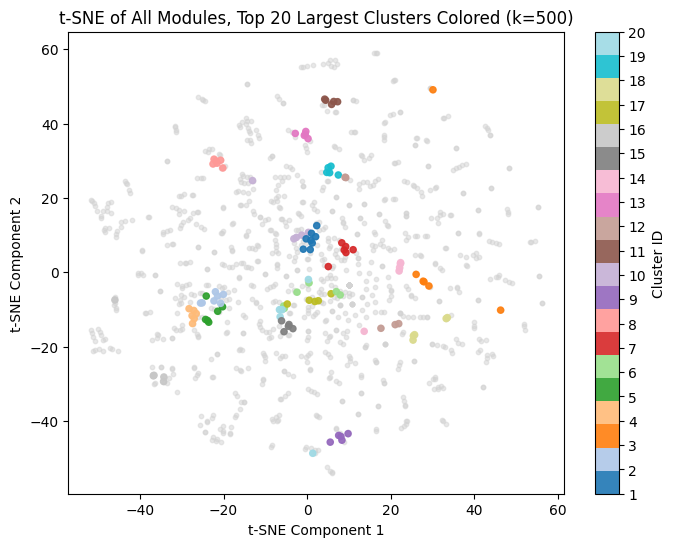

In [128]:
plot_kmeans_clusters(k_means, binary_feature_matrix)

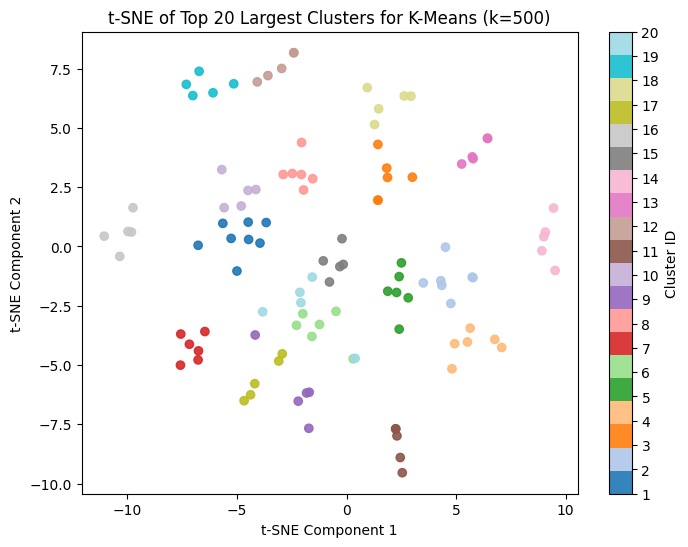

In [121]:
plot_kmeans_clusters(k_means, binary_feature_matrix)

In [96]:
# clusters = []
# for i in range(k):
#     clusters.append([mod for mod, fam in k_clustered_modules.items() if fam == i])
# clusters